In [94]:
from dotenv import load_dotenv
load_dotenv()

import os
import json
import re
import fitz  # PyMuPDF
import time
import logging
import sys
import textwrap
from typing import TypedDict, List, Dict, Optional, Any, Type

from pydantic import BaseModel, Field, ValidationError
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, END
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter


In [95]:
def setup_logger(name: str = "interview_bot") -> logging.Logger:
    logger = logging.getLogger(name)
    if not logger.handlers:
        logger.setLevel(logging.INFO)
        handler = logging.StreamHandler(sys.stdout)
        formatter = logging.Formatter(
            "[%(asctime)s] [%(levelname)s] [%(name)s] %(message)s",
            datefmt="%Y-%m-%d %H:%M:%S",
        )
        handler.setFormatter(formatter)
        logger.addHandler(handler)
    return logger

logger = setup_logger()


In [96]:
embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")


E0000 00:00:1761046553.234039   21295 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1761046553.235020   21295 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [97]:

def extract_text_from_pdf(pdf_path):
    text = ""
    with fitz.open(pdf_path) as doc:
        for page in doc:
            text += page.get_text("text") + "\n"
    return text

def chunk_cv_text(cv_text: str, user_id: str = "default_user") -> list:
    """Splits CV text into chunks for embedding and retrieval."""
    chunk_size = 800
    chunk_overlap = 200
    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)

    cv_text = cv_text.strip().replace("\n", " ")
    documents = []
    
    for i, chunk in enumerate(splitter.split_text(cv_text)):
        chunk_text = chunk.strip()
        if len(chunk_text) < 20:
            continue
        documents.append(Document(
            page_content=chunk_text,
            metadata={"user_id": user_id, "chunk_index": i}
        ))
    return documents

In [98]:

def create_vectorstore(documents: List[Document], user_id: str = "default_user"):
    """Create FAISS vectorstore from documents."""
    index_dir = os.path.join(os.getcwd(), f"faiss_index_{user_id}")
    vectorstore = FAISS.from_documents(documents, embeddings)
    vectorstore.save_local(index_dir)
    return vectorstore

In [99]:
# Install dotenv if not already
# !pip install python-dotenv tavily

import os
import logging
from dotenv import load_dotenv
from tavily import TavilyClient  # make sure tavily SDK is installed

# Load environment variables from .env
load_dotenv()  

TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
if not TAVILY_API_KEY:
    raise ValueError("TAVILY_API_KEY not found in environment variables!")

# Set up logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class TavilyService:
    """
    Wrapper for Tavily search API with logging and safe output.
    """

    def __init__(self, api_key: str):
        self.client = TavilyClient(api_key=api_key)

    def search(self, query: str, top_k: int = 5) -> list[str]:
        """
        Perform a search query using Tavily and return a list of text snippets.
        """
        try:
            response = self.client.search(query=query, top_k=top_k)
            results = response.get("results", [])
            snippets = [
                r.get("snippet") or r.get("content") or r.get("title", "")
                for r in results
            ][:top_k]
            logger.info(
                f"Tavily search successful: {len(snippets)} results for query '{query}'"
            )
            return snippets
        except Exception as e:
            logger.error(f"Tavily search failed for query '{query}': {e}")
            return []

# Initialize service
tavily_service = TavilyService(api_key=TAVILY_API_KEY)

# Example usage
results = tavily_service.search("machine learning interview questions", top_k=3)
for i, snippet in enumerate(results, 1):
    print(f"{i}. {snippet}")


[2025-10-21 14:35:54] [INFO] [__main__] Tavily search successful: 3 results for query 'machine learning interview questions'


INFO:__main__:Tavily search successful: 3 results for query 'machine learning interview questions'


1. Prepare for your interview with this comprehensive guide to machine learning questions, covering everything from basic concepts and algorithms to advanced and role-specific topics. * **Supervised Learning:** The model is trained on labeled data, where the target variable is known. * **Unsupervised Learning:** The model is trained on unlabeled data to find patterns or groupings. The hiring manager will ask machine learning interview questions about data processing, model training and validation, and advanced algorithms. If you do not have enough data to train a convolutional neural network, you can use transfer learning to train your model and get state-of-the-art results. * Select a methodology, algorithm, or machine learning model Learn to model and predict stock data values using linear models, decision trees, random forests, and neural networks.
2. # Introduction to Machine Learning Interviews Book ## Introduction to Machine Learning Interviews Book As a friend and teacher, I’ve 

In [100]:

# ===== RETRIEVAL DECISION =====

def decide_retrieval(question: str, user_id: str = "default_user"):
    """Decides whether to retrieve context based on the question."""
    try:
        index_dir = os.path.join(os.getcwd(), f"faiss_index_{user_id}")
        if not os.path.exists(index_dir):
            logger.warning("No FAISS index found, skipping retrieval.")
            return False, 1.0
        
        vectorstore = FAISS.load_local(
            index_dir,
            embeddings,
            allow_dangerous_deserialization=True
        )
        
        top_chunks = vectorstore.similarity_search_with_score(question, k=3)
        if not top_chunks:
            return False, 1.0

        min_distance = min(score for _, score in top_chunks)
        # Larger distance => less similar => need retrieval
        needs_retrieval = min_distance > 0.55
        
        return needs_retrieval, min_distance
        
    except Exception as e:
        logger.error(f"Retrieval decision error: {e}")
        return False, 1.0

# ===== STATE =====

In [101]:
from typing import List, Dict, Optional
from typing_extensions import TypedDict


class InterviewState(TypedDict):
    topic: str
    content: List[str]
    cv_content: str
    questions: List[str]
    answers: List[str]
    feedback: List[Dict]
    current_question: Optional[str]
    current_answer: Optional[str]
    step: int
    max_questions: int
    final_evaluation: Optional[Dict]
    messages: List[Dict]
    question_type: str
    needs_retrieval: bool
    retrieved_context: Optional[str]
    similarity_score: Optional[float]
    user_id: str
    tavily_snippets: List[str]


In [102]:
# ===== GEMINI CLIENT =====

class QuestionFeedback(BaseModel):
    rating: int = Field(0, ge=0, le=10)
    feedback: str = "No feedback"

class AnswerFeedback(BaseModel):
    rating: int = Field(0, ge=0, le=10)
    feedback: str = "No feedback"

class GeminiClient:
    """Wrapper around Gemini LLM API."""
    def __init__(self):
        self.model = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

    def generate_content(self, prompt: str) -> str:
        try:
            response = self.model.invoke(prompt)
            if hasattr(response, "content"):
                return response.content.strip()
            elif hasattr(response, "text"):
                return response.text.strip()
            else:
                return str(response).strip()
        except Exception as e:
            logger.error(f"Gemini generation failed: {e}")
            return "Tell me about your experience with this technology."
    def safe_parse_json(
        self, response_text: str, model: Type[BaseModel] = QuestionFeedback
    ) -> dict:
        """
        Safely parses a JSON string response from Gemini LLM and validates it using a Pydantic model.
        Returns a default model dictionary if parsing or validation fails.

        Args:
            response_text (str): The raw JSON string returned by Gemini LLM.
            model (Type[BaseModel], optional): Pydantic model class to validate JSON. Default is QuestionFeedback.

        Returns:
            dict: Validated dictionary according to the Pydantic model.
        """
        if not response_text or not response_text.strip():
            logger.warning("Empty response received; returning default model")
            return model().dict()

        # Extract JSON substring from the response
        match = re.search(r"\{.*\}", response_text, re.DOTALL)
        if match:
            try:
                data = json.loads(match.group(0))
                validated = model(**data)
                return validated.dict()
            except (json.JSONDecodeError, ValidationError) as e:
                logger.error(f"Failed to parse/validate JSON: {e}")
                return model().dict()
        logger.warning("No JSON found in response; returning default model")
        return model().dict()


gemini_client = GeminiClient()


E0000 00:00:1761046554.051234   21295 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [103]:
import os
import json
import time
import textwrap
from dataclasses import dataclass
from typing import Any, Dict, List, Mapping

from langchain_community.vectorstores import FAISS

logger = setup_logger(__name__)


# -------------------------
# Helpers
# -------------------------
def safe_prompt(fstring: str) -> str:
    return textwrap.dedent(fstring).strip()


def _safe_generate(prompt: str, fallback: str) -> str:
    try:
        return gemini_client.generate_content(prompt) or fallback
    except Exception as e:
        logger.error("Generation failed: %s", e)
        return fallback


def safe_parse_json(response: Any) -> Dict[str, Any]:
    fallback = {"rating": 6, "feedback": "Good effort. Could elaborate more."}
    if not response:
        return fallback

    if isinstance(response, dict):
        return response

    text = getattr(response, "text", None) or getattr(response, "content", None)
    if isinstance(response, str):
        text = response

    if not text:
        return fallback

    try:
        return json.loads(text)
    except Exception:
        try:
            start, end = text.find("{"), text.rfind("}") + 1
            return json.loads(text[start:end])
        except Exception:
            return {**fallback, "raw_text": text[:500]}


@dataclass
class FinalEvaluation:
    overall_quality: int
    strengths: List[str]
    areas_for_improvement: List[str]
    recommendation: str
    final_feedback: str

    def model_dump(self) -> Dict[str, Any]:
        return {
            "overall_quality": self.overall_quality,
            "strengths": self.strengths,
            "areas_for_improvement": self.areas_for_improvement,
            "recommendation": self.recommendation,
            "final_feedback": self.final_feedback,
        }


# -------------------------
# Retrieval Logic
# -------------------------
def decide_retrieval(query: str, user_id: str = "default_user"):
    """
    Decides whether retrieval is needed based on similarity scores.
    Returns (needs_retrieval, similarity_score)
    """
    try:
        index_dir = os.path.join(os.getcwd(), f"faiss_index_{user_id}")
        if not os.path.exists(index_dir):
            logger.warning("No FAISS index found, skipping retrieval.")
            return False, 1.0

        vectorstore = FAISS.load_local(
            index_dir, embeddings, allow_dangerous_deserialization=True
        )
        top_chunks = vectorstore.similarity_search_with_score(query, k=3)
        if not top_chunks:
            return False, 1.0

        min_distance = min(score for _, score in top_chunks)
        needs_retrieval = min_distance < 0.55
        return needs_retrieval, min_distance

    except Exception as e:
        logger.error(f"Retrieval decision error: {e}")
        return False, 1.0


# -------------------------
# Nodes
# -------------------------

def setup_node(state: Mapping[str, Any]) -> Dict[str, Any]:
    """Initializes interview state and retrieves context for topic."""
    topic = state.get("topic", "").strip()
    question_type = state.get("question_type", "broad_followup").strip()
    user_id = state.get("user_id", "default_user")

    retrieved_context = ""
    try:
        index_dir = os.path.join(os.getcwd(), f"faiss_index_{user_id}")
        if os.path.exists(index_dir):
            vectorstore = FAISS.load_local(
                index_dir, embeddings, allow_dangerous_deserialization=True
            )
            docs = vectorstore.similarity_search(topic, k=3)
            retrieved_context = "\n\n".join([doc.page_content for doc in docs])
            logger.info("Retrieved setup context for topic: %s", topic)
    except Exception as e:
        logger.error("Setup retrieval failed: %s", e)

    prompt = safe_prompt(get_setup_prompt(retrieved_context, topic, question_type))
    first_question = _safe_generate(
        prompt, "Tell me about your experience with this technology."
    )

    return {
        **state,
        "topic": topic,
        "question_type": question_type,
        "content": [retrieved_context or "No content"],
        "messages": [{"role": "user", "content": f"Interview topic: {topic}"}],
        "step": 0,
        "questions": [],
        "answers": [],
        "feedback": [],
        "current_question": first_question,
        "max_questions": state.get("max_questions", 3),
        "needs_retrieval": False,
        "use_tavily": False,
        "retrieved_context": retrieved_context,
        "similarity_score": 0.0,
    }


def get_answer_node(state: Mapping[str, Any]) -> Dict[str, Any]:
    """Collects user's answer."""
    current_q = state.get("current_question")
    if not current_q:
        raise ValueError("No current_question found in state.")

    answer = input(
        f"\n❓ Question {state.get('step', 0) + 1}: {current_q}\n💭 Your answer: "
    ).strip()

    new_messages = list(state.get("messages", [])) + [
        {"role": "interviewer", "content": current_q},
        {"role": "candidate", "content": answer},
    ]
    content_list = list(state.get("content", [])) + [f"Q: {current_q}\nA: {answer}"]

    return {
        **state,
        "current_answer": answer,
        "messages": new_messages,
        "questions": state.get("questions", []) + [current_q],
        "answers": state.get("answers", []) + [answer],
        "content": content_list,
    }


def retrieval_decision_node(state: Mapping[str, Any]) -> Dict[str, Any]:
    """Decides if retrieval or Tavily should be used."""
    current_answer = state.get("current_answer", "")
    user_id = state.get("user_id", "default_user")

    needs_retrieval, similarity_score = decide_retrieval(current_answer, user_id)
    use_tavily = not needs_retrieval  # mutually exclusive

    logger.info(
        "Retrieval decision: retrieval=%s, tavily=%s (similarity=%.2f)",
        needs_retrieval,
        use_tavily,
        similarity_score,
    )

    return {
        **state,
        "needs_retrieval": needs_retrieval,
        "use_tavily": use_tavily,
        "similarity_score": similarity_score,
    }


def retrieval_node(state: Mapping[str, Any]) -> Dict[str, Any]:
    """Performs retrieval only if needs_retrieval is True."""
    if not state.get("needs_retrieval", False):
        logger.info("Retrieval not needed, skipping retrieval_node.")
        return {**state, "retrieved_context": state.get("retrieved_context")}

    user_id = state.get("user_id", "default_user")
    query = state.get("current_answer", state.get("topic", ""))
    try:
        index_dir = os.path.join(os.getcwd(), f"faiss_index_{user_id}")
        vectorstore = FAISS.load_local(
            index_dir, embeddings, allow_dangerous_deserialization=True
        )
        docs = vectorstore.similarity_search(query, k=3)
        retrieved_context = "\n\n".join([doc.page_content for doc in docs])
        logger.info("Retrieved additional context for: %s", query[:50])
        return {**state, "retrieved_context": retrieved_context}
    except Exception as e:
        logger.error("Retrieval failed: %s", e)
        return {**state, "retrieved_context": None}


def tavily_search_node(state: Mapping[str, Any]) -> Dict[str, Any]:
    """Performs Tavily search if use_tavily=True (and retrieval not used)."""
    if not state.get("use_tavily", False):
        logger.info("Tavily search skipped (retrieval was used).")
        return state

    query = state.get("current_answer", state.get("topic", ""))
    if not query:
        logger.warning("No query available for Tavily search.")
        return state

    try:
        snippets = tavily_service.search(query, top_k=5)
        if snippets:
            enriched_context = (
                (state.get("retrieved_context") or "") + "\n\n" + "\n\n".join(snippets)
            )
            logger.info("Tavily search added %d snippets to context", len(snippets))
            return {**state, "retrieved_context": enriched_context}
        return state
    except Exception as e:
        logger.error("Tavily search failed: %s", e)
        return state


# (Keep the rest: generate_question_node, evaluate_question_node, final_evaluation_node, display_results_node)
# These remain unchanged.

def get_setup_prompt(topic: str, question_type: str) -> str:
    return f"""
    You are conducting a technical interview for a {topic} position.
    Generate an initial interview question that assesses basic knowledge and experience.
    """

def get_rag_setup_prompt(topic: str, question_type: str, context: str) -> str:
    return f"""
    You are conducting a technical interview for a {topic} position.

    Candidate Background:
    {context}

    Generate the first interview question that considers the candidate's experience.
    """

def get_question_generation_prompt(content: str, topic: str, step: int) -> str:
    return f"""
    Generate the next interview question for a {topic} position.

    Conversation so far:
    {content}

    Current step: {step + 1}

    Next question:
    """

def get_rag_question_generation_prompt(content: str, topic: str, step: int, context: str) -> str:
    return f"""
    Generate the next interview question for a {topic} position.

    Candidate Background:
    {context}

    Conversation so far:
    {content}

    Current step: {step + 1}

    Next question:
    """

# ===== UTIL =====

def safe_prompt(fstring: str) -> str:
    return textwrap.dedent(fstring).strip()

def _safe_generate(prompt: str, fallback: str) -> str:
    try:
        return gemini_client.generate_content(prompt) or fallback
    except Exception as e:
        logger.error("Generation failed: %s", e)
        return fallback

"""
Interview System Prompts
Centralized prompt templates for the AI Interviewer system
"""

import textwrap
from typing import Literal

# -------------------------------
# Utility functions
# -------------------------------

def safe_text(text: str, max_len: int = 2000) -> str:
    """
    Sanitize and truncate user-provided or large text to avoid context overflow
    and unwanted characters.
    """
    if not text:
        return ""
    sanitized = str(text).replace("\r", "").replace("\t", "    ")
    return sanitized[:max_len]

def build_prompt(role_desc: str, content: str, body: str) -> str:
    """
    Standard prompt builder to avoid duplication.
    Applies safe_text to content and strips extra whitespace.
    """
    return textwrap.dedent(f"""
        You are {role_desc}.
        Using the following reference content:
        {safe_text(content)}

        {body}
    """).strip()


# -------------------------------
# Setup and Initial Question Prompts
# -------------------------------

def get_setup_prompt(content_text: str, topic: str, question_type: str) -> str:
    """Prompt for generating the first question"""
    question_style = "Ask a broad, general question." if question_type.startswith('broad') else "Ask a specific, detailed question."
    body = f"Generate question #1 for the topic: {topic}.\n{question_style}\nReturn ONLY the question text."
    return build_prompt("an expert interviewer", content_text, body)


# -------------------------------
# Question Generation Prompts
# -------------------------------

def get_question_generation_prompt(content_text: str, prompt_instruction: str, topic: str, step: int) -> str:
    """Prompt for generating follow-up questions"""
    body = f"{prompt_instruction}\nTopic: {topic}\nQuestion number: {step + 1}\nReturn ONLY the question text."
    return build_prompt("an expert interviewer", content_text, body)

def get_question_instruction(is_followup: bool, is_broad: bool, previous_answer: str = "") -> str:
    """
    Generate the instruction part for question generation.
    Avoids awkward references when previous_answer is empty.
    """
    style = "broad, general" if is_broad else "specific, detailed"
    scope = "follow-up" if is_followup else "new aspect"

    if is_followup and previous_answer.strip():
        return f"Generate a {style} {scope} question that directly probes details from the previous answer: {previous_answer}"
    elif is_followup:
        return f"Generate a {style} {scope} question that builds on the previous discussion."
    else:
        return f"Generate a {style} {scope} question that explores a new aspect of the topic, independent of the previous answer."


# -------------------------------
# Generic Evaluation Prompt
# -------------------------------

def get_evaluation_prompt(
    kind: Literal["question", "answer"],
    full_messages: str,
    full_content: str,
    transcript: str,
    last_question: str = "",
    last_answer: str = ""
) -> str:
    """
    Generic evaluation prompt for either 'question' or 'answer'.
    Sanitizes all inputs and prevents exceeding context.
    """
    kind_desc = "question" if kind == "question" else "candidate answer"

    body = textwrap.dedent(f"""
        Evaluate the following {kind_desc} for its clarity, relevance, depth, and alignment with the topic,
        considering the ENTIRE interview history, accumulated context, all previous messages, questions, answers, and feedback.

        Full Interview History (Messages): {safe_text(full_messages)}
        Accumulated Context (Search Snippets): {safe_text(full_content)}
        Previous Q&A Transcript: {safe_text(transcript)}
        Current Question: {safe_text(last_question)}
        Current Candidate Answer: {safe_text(last_answer)}

        Provide a rating (1-10) for {kind_desc} quality and detailed feedback. Return JSON only, no extra text
    """)

    if kind == "answer":
        body += textwrap.dedent("""
            Return in JSON format:
            {
                "rating": 0,
                "feedback": "..."
            }
        """)

    return build_prompt("an expert interviewer", "", body)


# -------------------------------
# Final Evaluation Prompt
# -------------------------------

def get_final_evaluation_prompt(transcript: str) -> str:
    """Prompt for final evaluation of all questions"""
    body = textwrap.dedent(f"""
        Based on this transcript, produce a JSON summary evaluation of the questions:
        {safe_text(transcript)}
        return only JSON, no extra text
        JSON format ONLY, with explicit types:
        {{
            "overall_quality": 0,             # integer 1-10
            "strengths": ["..."],             # list of strings
            "areas_for_improvement": ["..."], # list of strings
            "recommendation": "...",          # string: keep/revise/remove
            "final_feedback": "..."           # string
        }}
    """).strip()
    return build_prompt("an expert interviewer", "", body)


In [109]:
import os
import json
import time
import textwrap
from dataclasses import dataclass
from typing import Any, Dict, List, Mapping

from langchain_community.vectorstores import FAISS

logger = setup_logger(__name__)


# -------------------------
# Helpers
# -------------------------
def safe_prompt(fstring: str) -> str:
    return textwrap.dedent(fstring).strip()


def _safe_generate(prompt: str, fallback: str) -> str:
    try:
        return gemini_client.generate_content(prompt) or fallback
    except Exception as e:
        logger.error("Generation failed: %s", e)
        return fallback


def safe_parse_json(response: Any) -> Dict[str, Any]:
    fallback = {"rating": 6, "feedback": "Good effort. Could elaborate more."}

    if not response:
        return fallback

    if isinstance(response, dict):
        return response

    text = None
    if hasattr(response, "text"):
        text = response.text
    elif hasattr(response, "content"):
        text = response.content
    elif isinstance(response, str):
        text = response

    if not text:
        return fallback

    try:
        return json.loads(text)
    except Exception:
        try:
            start, end = text.find("{"), text.rfind("}") + 1
            return json.loads(text[start:end])
        except Exception:
            return {**fallback, "raw_text": text[:500]}


@dataclass
class FinalEvaluation:
    overall_quality: int
    strengths: List[str]
    areas_for_improvement: List[str]
    recommendation: str
    final_feedback: str

    def model_dump(self) -> Dict[str, Any]:
        return {
            "overall_quality": self.overall_quality,
            "strengths": self.strengths,
            "areas_for_improvement": self.areas_for_improvement,
            "recommendation": self.recommendation,
            "final_feedback": self.final_feedback,
        }


# -------------------------
# Retrieval Logic
# -------------------------
def decide_retrieval(query: str, user_id: str = "default_user"):
    """Decides whether retrieval is needed based on similarity scores."""
    try:
        index_dir = os.path.join(os.getcwd(), f"faiss_index_{user_id}")
        if not os.path.exists(index_dir):
            logger.warning("No FAISS index found, skipping retrieval.")
            return False, 1.0

        vectorstore = FAISS.load_local(
            index_dir, embeddings, allow_dangerous_deserialization=True
        )
        top_chunks = vectorstore.similarity_search_with_score(query, k=3)
        if not top_chunks:
            return False, 1.0

        min_distance = min(score for _, score in top_chunks)
        needs_retrieval = min_distance < 0.55
        return needs_retrieval, min_distance

    except Exception as e:
        logger.error(f"Retrieval decision error: {e}")
        return False, 1.0


# -------------------------
# Nodes
# -------------------------
def setup_node(state: Mapping[str, Any]) -> Dict[str, Any]:
    """Initializes interview state and retrieves context for topic."""
    state = vars(state) if not isinstance(state, dict) else state

    topic = state.get("topic", "").strip()
    question_type = state.get("question_type", "broad_followup").strip()
    user_id = state.get("user_id", "default_user")

    retrieved_context = ""
    try:
        index_dir = os.path.join(os.getcwd(), f"faiss_index_{user_id}")
        if os.path.exists(index_dir):
            vectorstore = FAISS.load_local(
                index_dir, embeddings, allow_dangerous_deserialization=True
            )
            docs = vectorstore.similarity_search(topic, k=3)
            retrieved_context = "\n\n".join([doc.page_content for doc in docs])
            logger.info("Retrieved setup context for topic: %s", topic)
    except Exception as e:
        logger.error("Setup retrieval failed: %s", e)

    prompt = safe_prompt(get_setup_prompt(retrieved_context, topic, question_type))
    first_question = _safe_generate(
        prompt, "Tell me about your experience with this technology."
    )

    return {
        **state,
        "topic": topic,
        "question_type": question_type,
        "content": [retrieved_context or "No content"],
        "messages": [{"role": "user", "content": f"Interview topic: {topic}"}],
        "step": 0,
        "questions": [],
        "answers": [],
        "feedback": [],
        "current_question": first_question,
        "max_questions": state.get("max_questions", 3),
        "needs_retrieval": False,
        "retrieved_context": retrieved_context,
        "similarity_score": 0.0,
    }


def get_answer_node(state: Mapping[str, Any]) -> Dict[str, Any]:
    state = vars(state) if not isinstance(state, dict) else state

    current_q = state.get("current_question")
    if not current_q:
        raise ValueError("No current_question found in state.")

    answer = input(f"\n❓ Question {state.get('step', 0) + 1}: {current_q}\n💭 Your answer: ").strip()

    new_messages = list(state.get("messages", [])) + [
        {"role": "interviewer", "content": current_q},
        {"role": "candidate", "content": answer},
    ]
    content_list = list(state.get("content", [])) + [f"Q: {current_q}\nA: {answer}"]

    return {
        **state,
        "current_answer": answer,
        "messages": new_messages,
        "questions": state.get("questions", []) + [current_q],
        "answers": state.get("answers", []) + [answer],
        "content": content_list,
    }


def retrieval_decision_node(state: Mapping[str, Any]) -> Dict[str, Any]:
    state = vars(state) if not isinstance(state, dict) else state

    current_answer = state.get("current_answer", "")
    user_id = state.get("user_id", "default_user")

    needs_retrieval, similarity_score = decide_retrieval(current_answer, user_id)
    logger.info("Retrieval decision: %s (similarity: %.2f)", needs_retrieval, similarity_score)

    return {**state, "needs_retrieval": needs_retrieval, "similarity_score": similarity_score}


def retrieval_node(state: Mapping[str, Any]) -> Dict[str, Any]:
    state = vars(state) if not isinstance(state, dict) else state

    if not state.get("needs_retrieval", False):
        logger.info("Retrieval not needed, skipping retrieval_node.")
        return {**state, "retrieved_context": None}

    user_id = state.get("user_id", "default_user")
    query = state.get("current_answer", state.get("topic", ""))
    try:
        index_dir = os.path.join(os.getcwd(), f"faiss_index_{user_id}")
        vectorstore = FAISS.load_local(
            index_dir, embeddings, allow_dangerous_deserialization=True
        )
        docs = vectorstore.similarity_search(query, k=3)
        retrieved_context = "\n\n".join([doc.page_content for doc in docs])
        logger.info("Retrieved additional context for: %s", query[:50])
        return {**state, "retrieved_context": retrieved_context}
    except Exception as e:
        logger.error("Retrieval failed: %s", e)
        return {**state, "retrieved_context": None}


def tavily_search_node(state: Mapping[str, Any]) -> Dict[str, Any]:
    state = vars(state) if not isinstance(state, dict) else state

    query = state.get("current_answer", state.get("topic", ""))
    if not query:
        logger.warning("No query available for Tavily search.")
        return state

    try:
        snippets = tavily_service.search(query, top_k=5)
        if snippets:
            enriched_context = (
                (state.get("retrieved_context") or "") + "\n\n" + "\n\n".join(snippets)
            )
            logger.info("Tavily search added %d snippets to context", len(snippets))
            return {**state, "retrieved_context": enriched_context}
        return state
    except Exception as e:
        logger.error("Tavily search failed: %s", e)
        return state

def generate_question_node(state: InterviewState) -> InterviewState:
    """Generates the next interview question using RAG or Tavily context."""
    step = state["step"]
    max_questions = state["max_questions"]
    if step >= max_questions:
        logger.warning("Max questions reached. Skipping question generation.")
        return state

    topic = state["topic"]
    content_list = state.get("content", [])
    current_answer = state.get("current_answer", "")
    context_text = []

    # Determine which context to use
    if state.get("needs_retrieval", False) and state.get("retrieved_context"):
        context_text.append(state["retrieved_context"])
        context_sources = ["RAG"]
    elif state.get("tavily_snippets"):
        context_text.extend(state["tavily_snippets"])
        context_sources = ["Tavily"]
    else:
        context_sources = ["None"]

    # Logging for clarity
    logger.info(
        "Using %s context for question generation.", " + ".join(context_sources)
    )

    # Combine candidate content + context
    full_content = "\n".join(content_list + context_text)

    # Generate prompt
    prompt = get_rag_question_generation_prompt(
        full_content, topic, step, "\n".join(context_text)
    )

    # Generate question safely
    question = _safe_generate(
        prompt, f"Tell me more about your experience with {topic}."
    )

    state["current_question"] = question
    return state

def evaluate_question_node(state: Mapping[str, Any]) -> Dict[str, Any]:
    state = vars(state) if not isinstance(state, dict) else state

    questions, answers = state.get("questions", []), state.get("answers", [])
    if not questions or not answers:
        logger.warning("No Q/A to evaluate.")
        return state

    current_q, current_a = questions[-1], answers[-1]
    full_content = "\n".join(state.get("content", []))
    transcript = "\n".join([f"Q: {q}\nA: {a}" for q, a in zip(questions, answers)])
    messages_text = "\n".join([m.get("content", "") for m in state.get("messages", [])])

    try:
        q_raw = gemini_client.generate_content(
            get_evaluation_prompt(
                kind="question",
                full_messages=messages_text,
                full_content=full_content,
                transcript=transcript,
                last_question=current_q,
                last_answer=current_a,
            )
        )
        q_parsed = safe_parse_json(q_raw)

        a_raw = gemini_client.generate_content(
            get_evaluation_prompt(
                kind="answer",
                full_messages=messages_text,
                full_content=full_content,
                transcript=transcript,
                last_question=current_q,
                last_answer=current_a,
            )
        )
        a_parsed = safe_parse_json(a_raw)

    except Exception as e:
        logger.error("Evaluation failed: %s", e)
        q_parsed = {"rating": 6, "feedback": "Good effort."}
        a_parsed = {"rating": 6, "feedback": "Good effort."}

    feedback_list = list(state.get("feedback", []))
    feedback_list.append({"question_feedback": q_parsed, "answer_feedback": a_parsed})

    return {**state, "feedback": feedback_list, "step": state.get("step", 0) + 1}


def final_evaluation_node(state: Mapping[str, Any]) -> Dict[str, Any]:
    state = vars(state) if not isinstance(state, dict) else state

    questions, answers, feedback = (
        state.get("questions", []),
        state.get("answers", []),
        state.get("feedback", []),
    )
    if not questions or not answers:
        logger.warning("No data for final evaluation.")
        return state

    transcript = ""
    for i in range(len(questions)):
        fb = feedback[i] if i < len(feedback) else {}
        transcript += (
            f"Q{i+1}: {questions[i]}\nA{i+1}: {answers[i]}\n"
            f"Feedback: {fb.get('answer_feedback', {}).get('feedback', '')}\n\n"
        )

    final_prompt = get_final_evaluation_prompt(transcript)
    try:
        raw_final = gemini_client.generate_content(final_prompt)
        parsed_final = safe_parse_json(raw_final)
    except Exception as e:
        logger.error("Final eval parse failed: %s", e)
        parsed_final = {}

    final_eval = FinalEvaluation(
        overall_quality=int(parsed_final.get("overall_quality", 7)),
        strengths=parsed_final.get("strengths", ["Good technical depth"]),
        areas_for_improvement=parsed_final.get("areas_for_improvement", ["Elaborate examples"]),
        recommendation=parsed_final.get("recommendation", "Recommended with reservations."),
        final_feedback=parsed_final.get("final_feedback", "Solid overall performance."),
    )

    return {**state, "final_evaluation": final_eval.model_dump()}
def display_results_node(state: InterviewState) -> InterviewState:
    """Display interview results and answer feedback in console instead of saving to JSON."""
    user_id = state.get("user_id", "unknown_user")
    topic = state.get("topic", "unknown_topic")
    
    logger.info("🚀 Final evaluation for user '%s' on topic '%s':", user_id, topic)
    
    # Print per-question feedback
    questions = state.get("questions", [])
    answers = state.get("answers", [])
    feedback_list = state.get("feedback", [])
    
    print("\nINTERVIEW FEEDBACK PER QUESTION")
    print("-" * 70)
    for i, (q, a) in enumerate(zip(questions, answers)):
        print(f"Q{i+1}: {q}")
        print(f"A{i+1}: {a}")
        fb = feedback_list[i] if i < len(feedback_list) else {}
        answer_fb = fb.get("answer_feedback", {}).get("feedback", "No feedback")
        question_fb = fb.get("question_feedback", {}).get("feedback", "No feedback")
        print(f"Question Feedback: {question_fb}")
        print(f"Answer Feedback: {answer_fb}")
        print("-" * 70)
    
    # Print final evaluation
    final_eval = state.get("final_evaluation", {})
    if final_eval:
        print("\nFINAL EVALUATION")
        print("-" * 70)
        for key, value in final_eval.items():
            if isinstance(value, list):
                for item in value:
                    print(f" - {item}")
            else:
                print(f"{key}: {value}")
        print("=" * 70)
    
    return state


In [110]:
from langgraph.graph import StateGraph, END

logger = setup_logger(__name__)

# ===== GRAPH NODES =====
SETUP_NODE = "setup"
GET_ANSWER_NODE = "get_answer"
RETRIEVAL_DECISION_NODE = "retrieval_decision"
RETRIEVAL_NODE = "retrieval"
TAVILY_SEARCH_NODE = "tavily_search"
GENERATE_QUESTION_NODE = "generate_question"
EVALUATE_QUESTION_NODE = "evaluate_question"
FINAL_EVALUATION_NODE = "final_evaluation"
DISPLAY_RESULTS_NODE = "display_results"

# ===== LOGIC FUNCTIONS =====
def should_retrieve(state: InterviewState) -> str:
    """
    Decide whether to run RAG retrieval or Tavily search.
    - True  → RAG retrieval
    - False → Tavily
    """
    return RETRIEVAL_NODE if state["needs_retrieval"] else TAVILY_SEARCH_NODE


def should_continue(state: InterviewState) -> str:
    """Decide whether to continue the interview or move to final evaluation."""
    return GET_ANSWER_NODE if state["step"] < state["max_questions"] else FINAL_EVALUATION_NODE


def should_generate_question(state: InterviewState) -> str:
    """Prevent question generation if max questions reached."""
    return GENERATE_QUESTION_NODE if state["step"] < state["max_questions"] else FINAL_EVALUATION_NODE


# ===== GRAPH CONSTRUCTION =====
def create_interview_graph() -> StateGraph:
    logger.info("Initializing interview graph with RAG + Tavily search flow...")

    builder = StateGraph(InterviewState)

    # === Nodes ===
    builder.add_node(SETUP_NODE, setup_node)
    builder.add_node(GET_ANSWER_NODE, get_answer_node)
    builder.add_node(RETRIEVAL_DECISION_NODE, retrieval_decision_node)
    builder.add_node(RETRIEVAL_NODE, retrieval_node)
    builder.add_node(TAVILY_SEARCH_NODE, tavily_search_node)
    builder.add_node(GENERATE_QUESTION_NODE, generate_question_node)
    builder.add_node(EVALUATE_QUESTION_NODE, evaluate_question_node)
    builder.add_node(FINAL_EVALUATION_NODE, final_evaluation_node)
    builder.add_node(DISPLAY_RESULTS_NODE, display_results_node)

    # === Edges ===
    builder.set_entry_point(SETUP_NODE)

    # setup → get_answer → retrieval_decision
    builder.add_edge(SETUP_NODE, GET_ANSWER_NODE)
    builder.add_edge(GET_ANSWER_NODE, RETRIEVAL_DECISION_NODE)

    # retrieval_decision → either RAG or Tavily
    builder.add_conditional_edges(
        RETRIEVAL_DECISION_NODE,
        should_retrieve,
        {
            RETRIEVAL_NODE: RETRIEVAL_NODE,      # if True → RAG
            TAVILY_SEARCH_NODE: TAVILY_SEARCH_NODE,  # if False → Tavily
        },
    )

    # retrieval → generate_question
    builder.add_conditional_edges(
        RETRIEVAL_NODE,
        should_generate_question,
        {
            GENERATE_QUESTION_NODE: GENERATE_QUESTION_NODE,
            FINAL_EVALUATION_NODE: FINAL_EVALUATION_NODE,
        },
    )

    # tavily → generate_question
    builder.add_conditional_edges(
        TAVILY_SEARCH_NODE,
        should_generate_question,
        {
            GENERATE_QUESTION_NODE: GENERATE_QUESTION_NODE,
            FINAL_EVALUATION_NODE: FINAL_EVALUATION_NODE,
        },
    )

    # question → evaluate
    builder.add_edge(GENERATE_QUESTION_NODE, EVALUATE_QUESTION_NODE)

    # evaluate → continue or finish
    builder.add_conditional_edges(
        EVALUATE_QUESTION_NODE,
        should_continue,
        {
            GET_ANSWER_NODE: GET_ANSWER_NODE,
            FINAL_EVALUATION_NODE: FINAL_EVALUATION_NODE,
        },
    )

    # final → display → END
    builder.add_edge(FINAL_EVALUATION_NODE, DISPLAY_RESULTS_NODE)
    builder.add_edge(DISPLAY_RESULTS_NODE, END)

    logger.info("Interview graph successfully compiled (RAG ↔ Tavily logic enabled).")
    return builder.compile()


[2025-10-21 14:45:43] [INFO] [__main__] Initializing interview graph with RAG + Tavily search flow...


INFO:__main__:Initializing interview graph with RAG + Tavily search flow...


[2025-10-21 14:45:43] [INFO] [__main__] Interview graph successfully compiled (RAG ↔ Tavily logic enabled).


INFO:__main__:Interview graph successfully compiled (RAG ↔ Tavily logic enabled).


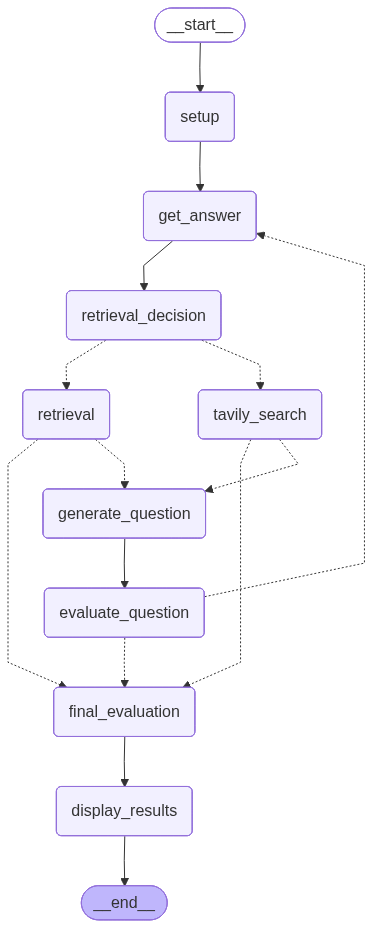

In [111]:
graph = create_interview_graph()
graph

### graph = create_interview_graph()
graph

[2025-10-21 14:45:43] [INFO] [__main__] Initializing interview graph with RAG + Tavily search flow...


INFO:__main__:Initializing interview graph with RAG + Tavily search flow...


[2025-10-21 14:45:43] [INFO] [__main__] Interview graph successfully compiled (RAG ↔ Tavily logic enabled).


INFO:__main__:Interview graph successfully compiled (RAG ↔ Tavily logic enabled).


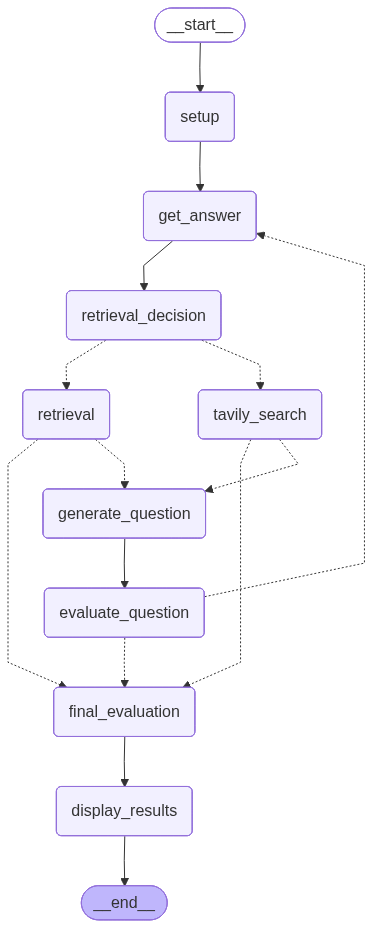

In [112]:

graph = create_interview_graph()
graph  # just evaluate this line


In [113]:

# ===== MAIN EXECUTION =====

if __name__ == "__main__":
    cv_path = input("Enter CV path: ").strip()
    cv_text = extract_text_from_pdf(cv_path)
    documents = chunk_cv_text(cv_text, user_id="user123")
    vectorstore = create_vectorstore(documents, user_id="user123")
    print(f"✅ CV processed: {len(documents)} chunks created and indexed.")

    topic = input("Enter interview topic/job title: ").strip()
    print("\nChoose question style:")
    print("1. Broad, follow-up questions (general, builds on previous answers)")
    print(
        "2. Narrow, follow-up questions (specific, probes details from previous answers)"
    )
    print("3. Broad, non-follow-up questions (general, new topic aspects)")
    print("4. Narrow, non-follow-up questions (specific, new topic aspects)")

    question_type_map = {
        "1": "broad_followup",
        "2": "narrow_followup",
        "3": "broad_nonfollowup",
        "4": "narrow_nonfollowup",
    }

    while True:
        choice = input("Enter choice (1-4): ").strip()
        if choice in question_type_map:
            question_type = question_type_map[choice]
            break
        print("⚠️ Invalid choice! Please enter 1, 2, 3, or 4.")

    interview_graph = create_interview_graph()

    initial_state = {
        "topic": topic,
        "content": [],
        "cv_content": cv_text[:1000],
        "questions": [],
        "answers": [],
        "feedback": [],
        "current_question": None,
        "current_answer": None,
        "step": 0,
        "max_questions": 3,
        "final_evaluation": None,
        "messages": [],
        "question_type": question_type,
        "needs_retrieval": False,
        "retrieved_context": None,
        "similarity_score": None,
        "user_id": "user123"
    }

    print("\n🚀 Starting interview...\n")
    final_state = interview_graph.invoke(initial_state)
    print("\n✅ Interview completed! Results saved in interview_results.json")


Enter CV path:  cv3.pdf


✅ CV processed: 7 chunks created and indexed.


Enter interview topic/job title:  js intern



Choose question style:
1. Broad, follow-up questions (general, builds on previous answers)
2. Narrow, follow-up questions (specific, probes details from previous answers)
3. Broad, non-follow-up questions (general, new topic aspects)
4. Narrow, non-follow-up questions (specific, new topic aspects)


Enter choice (1-4):  3


[2025-10-21 14:45:56] [INFO] [__main__] Initializing interview graph with RAG + Tavily search flow...


INFO:__main__:Initializing interview graph with RAG + Tavily search flow...


[2025-10-21 14:45:56] [INFO] [__main__] Interview graph successfully compiled (RAG ↔ Tavily logic enabled).


INFO:__main__:Interview graph successfully compiled (RAG ↔ Tavily logic enabled).



🚀 Starting interview...

[2025-10-21 14:45:57] [INFO] [__main__] Retrieved setup context for topic: js intern


INFO:__main__:Retrieved setup context for topic: js intern



❓ Question 1: Could you tell me about your experience and interest in JavaScript, and what aspects of it you're keen to explore further as an intern?
💭 Your answer:  yes i can, i worked as a full stack developer intern at inventra where i used frameworks like react


[2025-10-21 14:46:46] [INFO] [__main__] Retrieval decision: True (similarity: 0.38)


INFO:__main__:Retrieval decision: True (similarity: 0.38)


[2025-10-21 14:46:46] [INFO] [__main__] Retrieved additional context for: yes i can, i worked as a full stack developer inte


INFO:__main__:Retrieved additional context for: yes i can, i worked as a full stack developer inte


[2025-10-21 14:46:46] [INFO] [__main__] Using RAG context for question generation.


INFO:__main__:Using RAG context for question generation.



❓ Question 2: You mentioned using React for your e-commerce platform. Could you elaborate on a specific feature you implemented using React, and perhaps discuss any JavaScript concepts or React hooks you found particularly useful or challenging during that process?
💭 Your answer:  no i cant


[2025-10-21 14:48:59] [INFO] [__main__] Retrieval decision: False (similarity: 0.60)


INFO:__main__:Retrieval decision: False (similarity: 0.60)


[2025-10-21 14:49:00] [INFO] [__main__] Tavily search successful: 5 results for query 'no i cant'


INFO:__main__:Tavily search successful: 5 results for query 'no i cant'


[2025-10-21 14:49:00] [INFO] [__main__] Tavily search added 5 snippets to context


INFO:__main__:Tavily search added 5 snippets to context


[2025-10-21 14:49:00] [INFO] [__main__] Using None context for question generation.


INFO:__main__:Using None context for question generation.



❓ Question 3: No problem at all. Let's shift gears a bit. In modern JavaScript, we often use `let` and `const` for variable declarations instead of `var`. Could you explain the key differences between `var`, `let`, and `const`?
💭 Your answer:  idk sorry


[2025-10-21 14:50:10] [INFO] [__main__] Retrieval decision: False (similarity: 0.59)


INFO:__main__:Retrieval decision: False (similarity: 0.59)


[2025-10-21 14:50:11] [INFO] [__main__] Tavily search successful: 5 results for query 'idk sorry'


INFO:__main__:Tavily search successful: 5 results for query 'idk sorry'


[2025-10-21 14:50:11] [INFO] [__main__] Tavily search added 5 snippets to context


INFO:__main__:Tavily search added 5 snippets to context


[2025-10-21 14:50:11] [INFO] [__main__] Using None context for question generation.


INFO:__main__:Using None context for question generation.


[2025-10-21 14:50:42] [INFO] [__main__] 🚀 Final evaluation for user 'user123' on topic 'js intern':


INFO:__main__:🚀 Final evaluation for user 'user123' on topic 'js intern':



INTERVIEW FEEDBACK PER QUESTION
----------------------------------------------------------------------
Q1: Could you tell me about your experience and interest in JavaScript, and what aspects of it you're keen to explore further as an intern?
A1: yes i can, i worked as a full stack developer intern at inventra where i used frameworks like react
Question Feedback: This question is excellent as an opening for a 'JavaScript Intern' interview. It is highly clear, directly relevant to the role, and designed to elicit a comprehensive response. It asks about both past experience and future interests, which provides insight into the candidate's skills and their motivation for the internship.

Considering the accumulated context, which lists 'JavaScript' as a programming language and 'React' in a project, the question perfectly aligns with the candidate's stated abilities. The current answer, while brief, confirms some relevant experience (full stack intern, React frameworks), indicating the q